# Fitting Sigmoid functions to empirical NN distribution


4/11/2022
Shiqi Jiang

In [1]:
# 9 Species: AT, CE, DM, ...
# 8 Classes: ER, ERDD, GEO, GEOGD ...(each with ~500 data points)
# normalization is done on each species seperetaly.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import erf
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import mean_absolute_error as MSE

### normalization on AT

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky','Original']
data_locations = [r"/content/drive/MyDrive/Adaptable-Sigmoids/data/AT"+c for c in classes]
data_locations_CE = [r"/content/drive/MyDrive/Adaptable-Sigmoids/data/CE"+c for c in classes]

In [5]:
def combine_data(data_location,classes):
    df_comb = pd.DataFrame()
    i = 0
    for protein in data_location:
        df = pd.read_csv(protein, header = None, sep = ' ')
        df['class'] = classes[i]
        df_comb = pd.concat([df, df_comb])
        i += 1
    return df_comb

In [6]:
df_comb = combine_data(data_locations,classes)
df_class = df_comb['class']
df_comb = df_comb.drop("class", axis = 1)
df_comb = pd.DataFrame(MinMaxScaler().fit_transform(df_comb))
df_comb['class'] = df_class.reset_index(drop = True)



In [7]:
df_CE = combine_data(data_locations_CE,classes)
df_class_CE = df_CE['class']
df_CE = df_CE.drop("class", axis = 1)
df_CE = pd.DataFrame(MinMaxScaler().fit_transform(df_CE))
df_CE['class'] = df_class_CE.reset_index(drop = True)

In [8]:
# calling data(data_frame, class_name) return Species-Class empirical data as an array
def data(dataframe, class_name):
    return dataframe[dataframe['class']==class_name].drop("class",axis=1).to_numpy()

### helper functions

In [24]:
# calculating empirical data's shortest(NN) distance 
# real data is high-dimensional data points

def histedges_equalN(x, nbin):
  npt = len(x)
  return np.interp(np.linspace(0, npt, nbin + 1),
                    np.arange(npt),
                    np.sort(x))

def data_distance(data):
    shortest_distance = [0]*len(data)
    for i in range(len(data)):
        x = np.delete(data,i,0)
        temp = (x-data[i])**2
        d = np.sqrt(np.sum(temp,axis=1))
        shortest_distance[i] = d.min()
    
    return np.array(shortest_distance)   # return an array of real data's NN distance


# plotting empirical data's NN hist
def plot_data_distance(D, title):
    """
    D: an array of real data' NN distance
    """
    f, ax = plt.subplots(1,1, figsize = (6,4))
    ax.hist(D,edgecolor='white', bins = 100)   ## consider specifying <bins>, histedges_equalN
    ax.set_title(title)
    plt.show()
    return


# get x,y data from CDF of empirical NN
def empirical_CDF(data, Density,title):
    '''
    return x,y data of CDF
    if density==True, y is percentage where y[-1]=1 
    '''    
    fig = plt.figure()
    h = plt.hist(data,bins=len(data),density=Density,cumulative=True,histtype='stepfilled')    # bins set to equal to # of empirical data
    x = h[1][:-1]
    y = h[0]
    plt.close(fig)
    ##plt.show()
    return x,y


# curve_fit()
def auto_curve_fit(data_NN, x, y, x_scale_factor, func,s, p_control=None):
    '''
    data_NN: array empirical data_distance for calculating median
    x,y: from CDF
    s: sigma in curve_fit(), for weighting
    '''
    if p_control == "Gompertz":
        p0 = [1,1]
    elif p_control == "Weight":
        p0 = [np.median(data_NN)/x_scale_factor,1,0.5]
    else:
        p0 = [np.median(data_NN)/x_scale_factor,1] # this is initial guess for sigmoid parameters
    
    popt, pcov = curve_fit(f=func, xdata=x/x_scale_factor, ydata=y, p0=p0,method='lm', sigma=y)

    # parameters yielded by Curve_fit: x0, k
    print("curve_fit parameter on "+str(func.__name__)+": ", popt)
    return popt


# plot fitted sigmoid and empirical curve in 1-y and y: i.e. y-axis = p-value and CDF
def sigmoids_for_class(data, name, factor, func_list, color_list, binning):
    if binning:
        x,y = binning_xy(data_binning(data))
    else:
        x,y = empirical_CDF(data, name)
    
    global mse_list
    mse_list = []
    
    # axis[0] = 1-y = p_value (on log space)
    # axis[1] = y = CDF
    f,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('1-y(p_value) of '+name)
    ax[0].set_yscale('log')
    ax[0].scatter(x,1-y, color='b',s=10)
    
    ax[1].set_title('y of '+name)
    ax[1].scatter(x,y, color='b',s=10)
    
    print("For ",name," :")
    for i,sig in enumerate(func_list):
        try:
            if sig.__name__ == "Gompertz":
                p = auto_curve_fit(data,x,y,factor,sig,s=y,p_control="Gompertz")
                print()
            elif sig.__name__ == "arctan_GD":
                p = auto_curve_fit(data,x,y,factor,sig,s=y,p_control="Weight")
            else:
                p = auto_curve_fit(data,x,y,factor,sig,s=y)
        except RuntimeError:
            print("error in ",str(sig.__name__))
            continue
        y2 = sig(x/factor, *p)
        ax[0].plot(x, 1-y2, color=color_list[i], label=str(sig.__name__), alpha = 0.9,) #plot
        ax[1].plot(x, y2, color=color_list[i], label=str(sig.__name__), alpha = 0.9,) #plot
        mse_list.append(MSE(1-y, 1-y2)) #appending mse for each class in respect to each sigmoid
    
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')

    plt.show()



### Sigmoid functions

In [25]:
# 4.11 Adjust range to (0,1)

def logistic(x,x0, k):
    m = (1/ (1 + np.exp(-k*(x-x0))))      
    return m

def tanh(x, x0, k): # for log curve_fit
    m = (1+np.tanh(k*(x-x0)))/2
    return m

def arctan(x, x0, k):
    m = 0.5*(2/np.pi)*np.arctan(k*(x-x0)) + 0.5
    return m

def GD(x, x0, k):
    m = (4/np.pi)*np.arctan(np.tanh(k*(x-x0)))
    return m

def ERF(x, x0, k):
    m = erf(k*(x-x0))
    return m

def algebra(x, x0, k):
    m = x/((1+abs(x)**k)**(1/k))
    return m

### 3.7 meeting.  Weighted_combination of arctan+GD
def arctan_GD(x,x0,k, w):
    m = w*GD(x,x0,k)+(1-w)*arctan(x,x0,k)
    return m

def Gompertz(x,b,c):
    m = np.e**(-np.e**(b-c*x))
    return m

Binning

In [26]:
def data_binning(data):
    
    x = np.sort(data) 
    N = len(x)                   # e.g N = 500, sqrt(500)=22.3
    lower = int(np.floor(np.sqrt(N))) # 22
    upper = int(np.ceil(np.sqrt(N)))  # 23 as total #of bin
    
    if lower*upper >= N:
        small_bin_num = int(lower*upper - N)  # 22*23 - 500 = 6
        small_bin_size = int(lower - 1)  # 21
        large_bin_size = lower
    else: # HGG -> sqrt(252) = 15.8
        small_bin_num = int(upper**2 - N) # 16*16-252 =4
        small_bin_size = lower  # 15
        large_bin_size = upper
    
    large_bin_num = int(upper - small_bin_num) # 23-6 = 17

    # small_bin_size*small_bin_num + lower*large_bin_num = N

    bin_count = [large_bin_size]*large_bin_num + [small_bin_size]*small_bin_num  # [22..*17, 21..*6,]
    print("items in each bin: ", bin_count)
    binned_data = []
    i = 0
    for count in bin_count:
        binned_data.append(np.mean(x[i:i+count]))
        i += count
    
    return binned_data


def binning_xy(binned_data):
    x = np.concatenate(([0],binned_data))
    y = np.zeros((x.shape))
    
    for i in range(1,len(x)):
        y[i] = i/len(x)
        
    return x,y

### Fitting

In [27]:
classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky','Original']
factors = [1e-5,  1e-2,   1e-4,   1e-3,   1e-2,  1e-4, 1e-2,   1e-3]
colors = ['g','c','m','y','k','brown','gray','r']
functions = [logistic, tanh, arctan, GD, ERF, algebra, arctan_GD, Gompertz]

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  ER  :
curve_fit parameter on logistic:  [4.74320923 1.        ]
curve_fit parameter on tanh:  [4.74320923 1.        ]
curve_fit parameter on arctan:  [4.74320923 1.        ]
curve_fit parameter on GD:  [4.74320923 1.        ]
curve_fit parameter on ERF:  [4.74320923 1.        ]
curve_fit parameter on algebra:  [4.74320923 1.        ]
curve_fit parameter on arctan_GD:  [4.74320923 1.         0.5       ]
curve_fit parameter on Gompertz:  [1. 1.]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-package

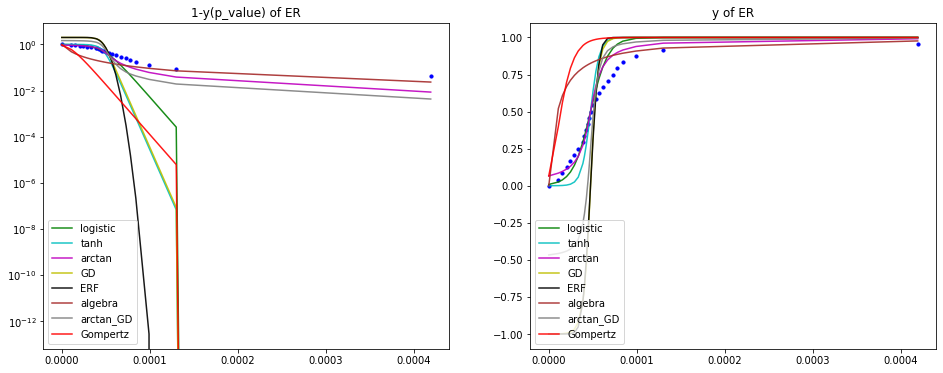

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ERDD  :
curve_fit parameter on logistic:  [1.01217827 1.        ]
curve_fit parameter on tanh:  [1.01217827 1.        ]
curve_fit parameter on arctan:  [1.01217827 1.        ]
curve_fit parameter on GD:  [1.01217827 1.        ]
curve_fit parameter on ERF:  [1.01217827 1.        ]
curve_fit parameter on algebra:  [1.01217827 1.        ]
curve_fit parameter on arctan_GD:  [1.01217827 1.         0.5       ]
curve_fit parameter on Gompertz:  [1. 1.]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-package

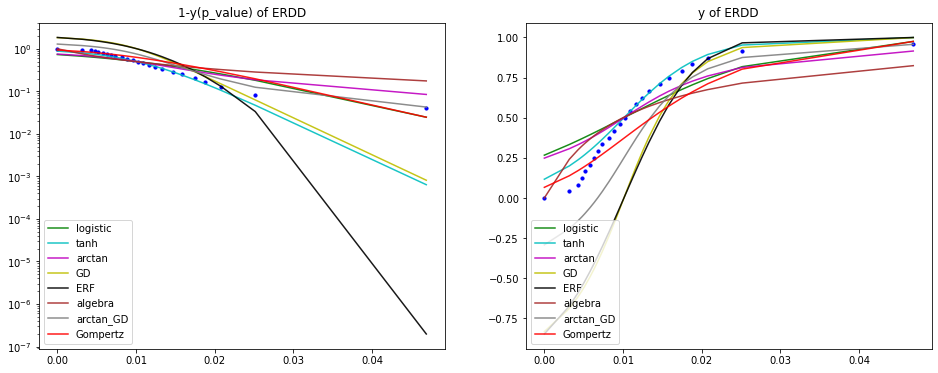

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  GEO  :
curve_fit parameter on logistic:  [2.07712928 1.        ]
curve_fit parameter on tanh:  [2.07712928 1.        ]
curve_fit parameter on arctan:  [2.07712928 1.        ]
curve_fit parameter on GD:  [2.07712928 1.        ]
curve_fit parameter on ERF:  [2.07712928 1.        ]
curve_fit parameter on algebra:  [2.07712928 1.        ]
curve_fit parameter on arctan_GD:  [2.07712928 1.         0.5       ]
curve_fit parameter on Gompertz:  [1. 1.]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-package

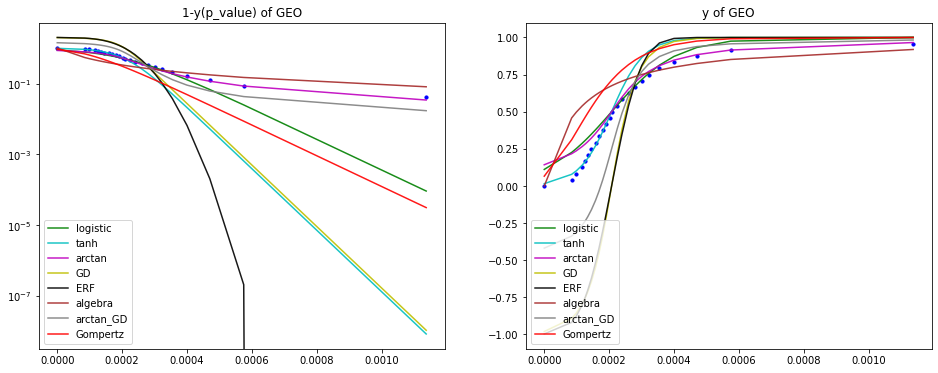

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  GEOGD  :
curve_fit parameter on logistic:  [0.35420422 1.        ]
curve_fit parameter on tanh:  [0.35420422 1.        ]
curve_fit parameter on arctan:  [0.35420422 1.        ]
curve_fit parameter on GD:  [0.35420422 1.        ]
curve_fit parameter on ERF:  [0.35420422 1.        ]
curve_fit parameter on algebra:  [0.35420422 1.        ]
curve_fit parameter on arctan_GD:  [0.35420422 1.         0.5       ]
curve_fit parameter on Gompertz:  [1. 1.]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-package

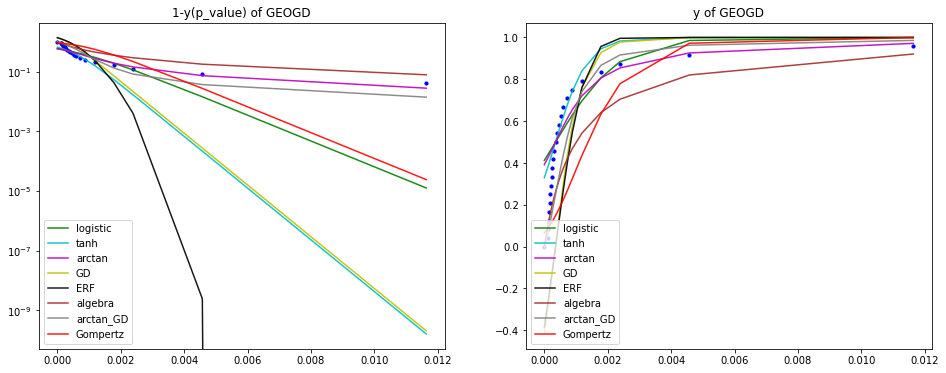

items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
For  HGG  :
curve_fit parameter on logistic:  [8.94144704 1.        ]
curve_fit parameter on tanh:  [8.94144704 1.        ]
curve_fit parameter on arctan:  [8.94144704 1.        ]
curve_fit parameter on GD:  [8.94144704 1.        ]
curve_fit parameter on ERF:  [8.94144704 1.        ]
curve_fit parameter on algebra:  [8.94144704 1.        ]
curve_fit parameter on arctan_GD:  [8.94144704 1.         0.5       ]
curve_fit parameter on Gompertz:  [1. 1.]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-package

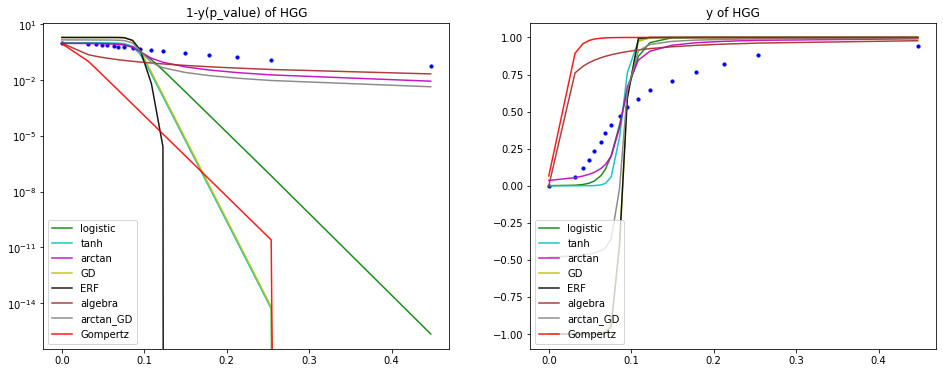

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  SF  :
curve_fit parameter on logistic:  [2.82972287 1.        ]
curve_fit parameter on tanh:  [2.82972287 1.        ]
curve_fit parameter on arctan:  [2.82972287 1.        ]
curve_fit parameter on GD:  [2.82972287 1.        ]
curve_fit parameter on ERF:  [2.82972287 1.        ]
curve_fit parameter on algebra:  [2.82972287 1.        ]
curve_fit parameter on arctan_GD:  [2.82972287 1.         0.5       ]
curve_fit parameter on Gompertz:  [1. 1.]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-package

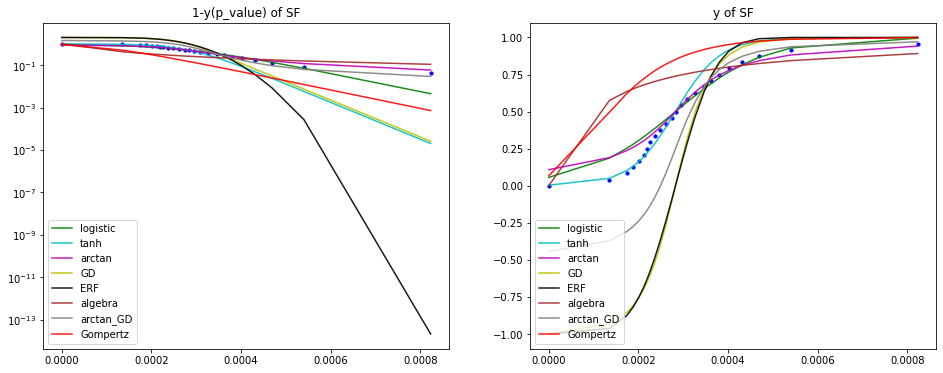

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  SFDD  :
curve_fit parameter on logistic:  [1.55198565 1.        ]
curve_fit parameter on tanh:  [1.55198565 1.        ]
curve_fit parameter on arctan:  [1.55198565 1.        ]
curve_fit parameter on GD:  [1.55198565 1.        ]
curve_fit parameter on ERF:  [1.55198565 1.        ]
curve_fit parameter on algebra:  [1.55198565 1.        ]
curve_fit parameter on arctan_GD:  [1.55198565 1.         0.5       ]
curve_fit parameter on Gompertz:  [1. 1.]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-package

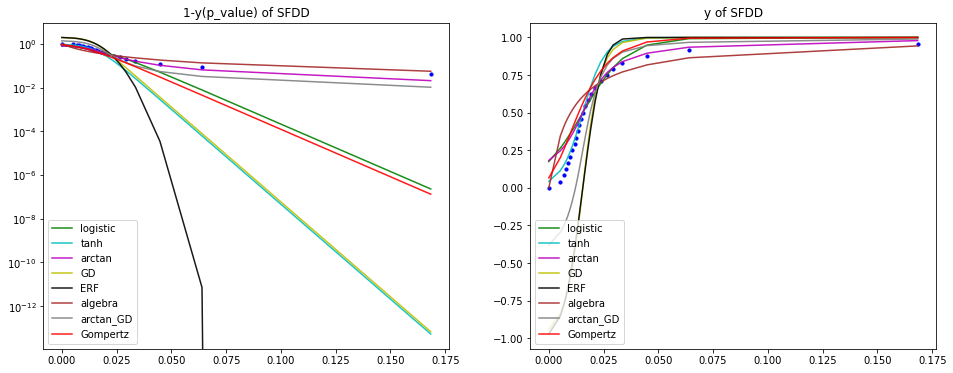

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  Sticky  :
curve_fit parameter on logistic:  [5.49479545 1.        ]
curve_fit parameter on tanh:  [5.49479545 1.        ]
curve_fit parameter on arctan:  [5.49479545 1.        ]
curve_fit parameter on GD:  [5.49479545 1.        ]
curve_fit parameter on ERF:  [5.49479545 1.        ]
curve_fit parameter on algebra:  [5.49479545 1.        ]
curve_fit parameter on arctan_GD:  [5.49479545 1.         0.5       ]
curve_fit parameter on Gompertz:  [1. 1.]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-package

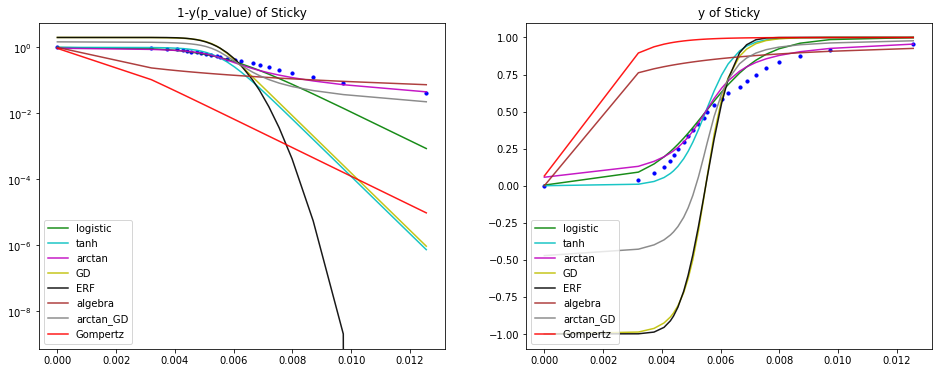

In [29]:
class_mse_list = []
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_comb,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors[i], functions, colors, binning = True)
    class_mse_list.append(mse_list) #2d array of each class having mse list in respect to each sigmoid

In [13]:
def MSE_df(classes, MSEs, sigmoids):
  sig_df = pd.DataFrame()
  sig_df['sigmoids'] = [class_name.__name__ for class_name in sigmoids]
  for i,class_name in enumerate(classes[:-1]):
    sig_df['{class_name}'.format(class_name = class_name)] = MSEs[i]
  return sig_df

# WITHOUT FIXED BINS

In [23]:
sig_df = MSE_df(classes, class_mse_list, functions)
for class_name in classes[:-1]:
  class_string = '{class_name}'.format(class_name = class_name)
  print(sig_df[sig_df[class_string]==sig_df[class_string].min()]['sigmoids'], sig_df[class_string].min())

6    arctan_GD
Name: sigmoids, dtype: object 0.006719882862531577
6    arctan_GD
Name: sigmoids, dtype: object 0.018350074320921526
6    arctan_GD
Name: sigmoids, dtype: object 0.012671270007557878
6    arctan_GD
Name: sigmoids, dtype: object 0.017079353955667877
6    arctan_GD
Name: sigmoids, dtype: object 0.028208634800675574
7    Gompertz
Name: sigmoids, dtype: object 0.007906828044352355
6    arctan_GD
Name: sigmoids, dtype: object 0.013464588995027189
7    Gompertz
Name: sigmoids, dtype: object 0.011784519515148863


# WITH FIXED BINS (SHIQI'S METHOD)

In [30]:
sig_df = MSE_df(classes, class_mse_list, functions)
for class_name in classes[:-1]:
  class_string = '{class_name}'.format(class_name = class_name)
  print(sig_df[sig_df[class_string]==sig_df[class_string].min()]['sigmoids'], sig_df[class_string].min())

2    arctan
Name: sigmoids, dtype: object 0.055924759741113515
1    tanh
Name: sigmoids, dtype: object 0.047837028809262765
2    arctan
Name: sigmoids, dtype: object 0.05368764917704492
1    tanh
Name: sigmoids, dtype: object 0.11638437557278734
2    arctan
Name: sigmoids, dtype: object 0.14201380911432399
2    arctan
Name: sigmoids, dtype: object 0.04620516326154104
1    tanh
Name: sigmoids, dtype: object 0.05837354722311722
2    arctan
Name: sigmoids, dtype: object 0.0448953024371318


In [31]:
sig_df

,sigmoids,ER,ERDD,GEO,GEOGD,HGG,SF,SFDD,Sticky
0,logistic,0.066186,0.122353,0.063330,0.145170,0.168283,0.054458,0.081784,0.051873
1,tanh,0.132792,0.047837,0.060318,0.116384,0.209653,0.050767,0.058374,0.107463
2,arctan,0.055925,0.107261,0.053688,0.131957,0.142014,0.046205,0.064507,0.044895
3,GD,0.598924,0.444033,0.493317,0.348234,0.713643,0.505000,0.474120,0.557556
4,ERF,0.601651,0.440185,0.496283,0.345168,0.714652,0.508704,0.474729,0.565142
5,algebra,0.296906,0.116952,0.189504,0.157707,0.369460,0.246789,0.138455,0.337519
6,arctan_GD,0.319762,0.198669,0.225329,0.131245,0.425743,0.229904,0.210941,0.281210
7,Gompertz,0.396588,0.103739,0.202626,0.223030,0.463211,0.319535,0.097556,0.463611


#### CE

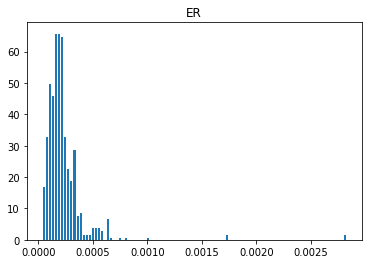

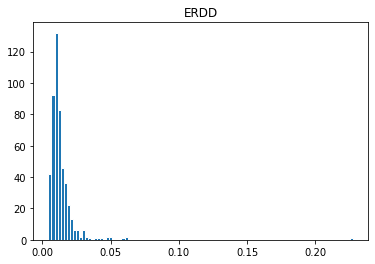

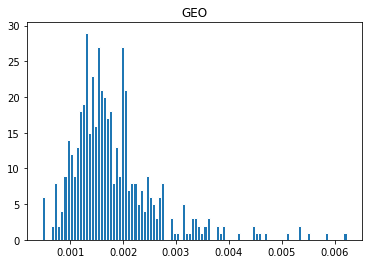

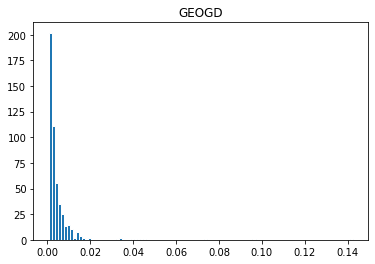

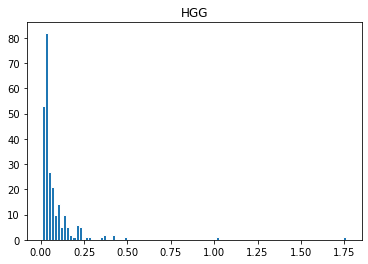

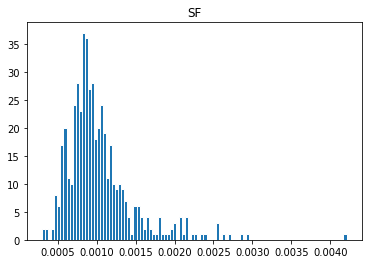

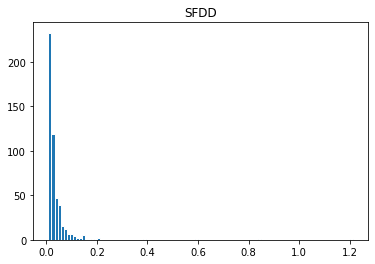

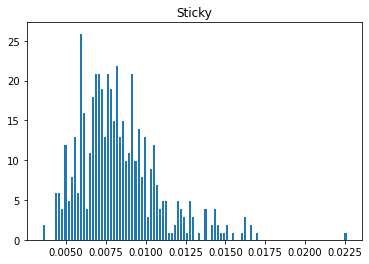

In [15]:
c = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky']
for i in c:
    data_i = data_distance(data(df_CE,i))
    plot_data_distance(data_i,i)

In [16]:
erdd = data_distance(data(df_CE,'ERDD'))
empirical_CDF(erdd,True,"ERDD")

(array([0.00446796, 0.00491375, 0.00535953, 0.00580532, 0.00625111,
        0.00669689, 0.00714268, 0.00758847, 0.00803426, 0.00848004,
        0.00892583, 0.00937162, 0.0098174 , 0.01026319, 0.01070898,
        0.01115476, 0.01160055, 0.01204634, 0.01249212, 0.01293791,
        0.0133837 , 0.01382949, 0.01427527, 0.01472106, 0.01516685,
        0.01561263, 0.01605842, 0.01650421, 0.01694999, 0.01739578,
        0.01784157, 0.01828736, 0.01873314, 0.01917893, 0.01962472,
        0.0200705 , 0.02051629, 0.02096208, 0.02140786, 0.02185365,
        0.02229944, 0.02274523, 0.02319101, 0.0236368 , 0.02408259,
        0.02452837, 0.02497416, 0.02541995, 0.02586573, 0.02631152,
        0.02675731, 0.02720309, 0.02764888, 0.02809467, 0.02854046,
        0.02898624, 0.02943203, 0.02987782, 0.0303236 , 0.03076939,
        0.03121518, 0.03166096, 0.03210675, 0.03255254, 0.03299833,
        0.03344411, 0.0338899 , 0.03433569, 0.03478147, 0.03522726,
        0.03567305, 0.03611883, 0.03656462, 0.03

In [17]:
np.sort(erdd)

array([0.00446796, 0.00446796, 0.00465987, 0.00465987, 0.0053608 ,
       0.0053608 , 0.00540052, 0.00540052, 0.00542853, 0.00542853,
       0.00557916, 0.00557916, 0.00559739, 0.00559739, 0.0057245 ,
       0.0057245 , 0.00579291, 0.00579291, 0.00583841, 0.00583841,
       0.00610969, 0.00610969, 0.00625552, 0.00625552, 0.0062566 ,
       0.0062566 , 0.00645246, 0.00645246, 0.00646638, 0.00646638,
       0.00651589, 0.00651589, 0.00653543, 0.00653543, 0.00654309,
       0.00654309, 0.0065677 , 0.0065677 , 0.00663338, 0.00663338,
       0.00667302, 0.00667302, 0.00690438, 0.00690438, 0.00706179,
       0.00706179, 0.00710276, 0.00713604, 0.00713604, 0.00716562,
       0.00719857, 0.00728046, 0.00728046, 0.00728869, 0.00728869,
       0.00729327, 0.00729327, 0.00730514, 0.00730514, 0.00736613,
       0.00736613, 0.00740942, 0.00748016, 0.00753721, 0.00753721,
       0.00755001, 0.00759992, 0.00759992, 0.00760211, 0.00760211,
       0.00761367, 0.00761367, 0.00763186, 0.00763186, 0.00767

In [18]:
# 4.11
## 1 without binning

##2 same # of items in each bin
## => sqrt(n) bins -> sqrt(n) pts/bin 
# x=0, y=0
## y(x_1) = 1/n+1
## y(x_i) = i/n+1

In [19]:
factors_CE = [1e-4, 1e-2, 1e-3, 1e-2,1e-1, 1e-4, 1e-1, 1e-4]

For  ER  :
curve_fit parameter on logistic:  [1.73029012 3.38918075]
curve_fit parameter on tanh:  [1.7302839 1.6945982]
curve_fit parameter on arctan:  [ 1.74675384 18.40658771]
curve_fit parameter on GD:  [0.36841091 0.20617268]
curve_fit parameter on ERF:  [0.36751552 0.22688236]
curve_fit parameter on algebra:  [1.8709861  0.24981659]
curve_fit parameter on arctan_GD:  [1.65509296 1.18532506 0.16052449]
curve_fit parameter on Gompertz:  [2.11160151 1.38512701]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


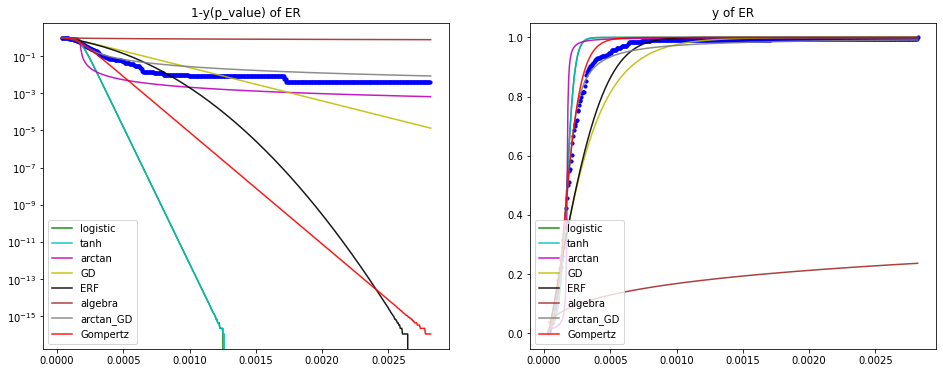

For  ERDD  :
curve_fit parameter on logistic:  [1.00412187 8.39484188]
curve_fit parameter on tanh:  [1.00412544 4.19739141]
curve_fit parameter on arctan:  [ 1.02273372 43.020908  ]
curve_fit parameter on GD:  [0.45566823 0.44528104]
curve_fit parameter on ERF:  [0.45520221 0.49040874]
curve_fit parameter on algebra:  [1.08467194 0.27354095]
curve_fit parameter on arctan_GD:  [0.98672352 3.51754731 0.13458501]
curve_fit parameter on Gompertz:  [3.16261802 3.40788745]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


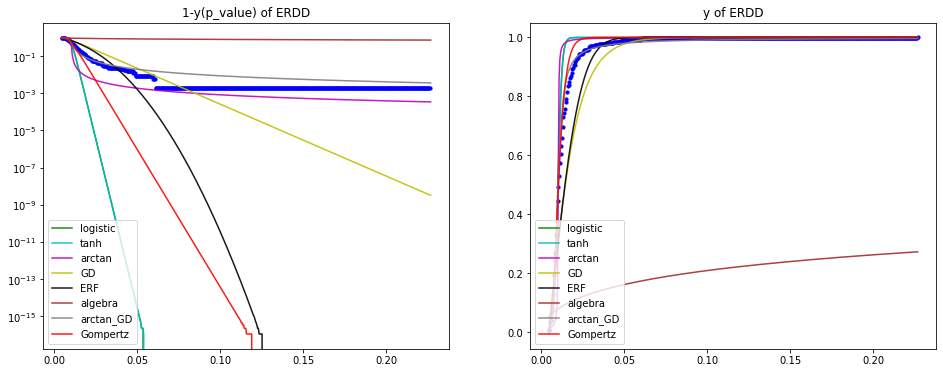

For  GEO  :
curve_fit parameter on logistic:  [1.57333799 4.46734094]
curve_fit parameter on tanh:  [1.57333917 2.23366802]
curve_fit parameter on arctan:  [ 1.55347357 24.08099722]
curve_fit parameter on GD:  [0.49831651 0.17160968]
curve_fit parameter on ERF:  [0.49834157 0.19374113]
curve_fit parameter on algebra:  [1.6242431  0.17848783]
curve_fit parameter on arctan_GD:  [1.5545816  2.84699229 0.088618  ]
curve_fit parameter on Gompertz:  [2.55634679 1.72770579]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


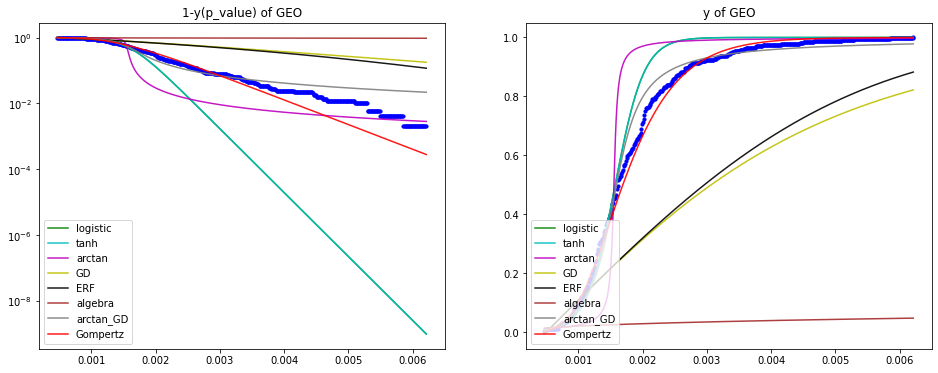

For  GEOGD  :
curve_fit parameter on logistic:  [ 0.24539349 17.18409571]
curve_fit parameter on tanh:  [0.24539358 8.5920428 ]
curve_fit parameter on arctan:  [ 0.22982107 34.05223458]
curve_fit parameter on GD:  [0.05980736 2.27005773]
curve_fit parameter on ERF:  [0.05855419 2.37158207]
curve_fit parameter on algebra:  [0.24724461 9.53942847]
curve_fit parameter on arctan_GD:  [0.13118353 3.21519496 0.59813823]
curve_fit parameter on Gompertz:  [1.77629292 8.74636378]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


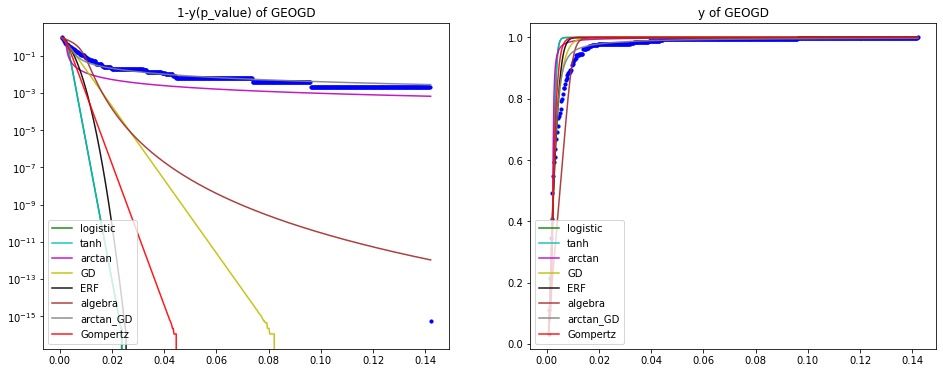

For  HGG  :
curve_fit parameter on logistic:  [ 0.36520047 12.06389831]
curve_fit parameter on tanh:  [0.36519863 6.03199126]
curve_fit parameter on arctan:  [ 0.35732069 30.79836035]
curve_fit parameter on GD:  [0.06768323 1.28549534]
curve_fit parameter on ERF:  [0.06646829 1.35831269]
curve_fit parameter on algebra:  [0.40294287 3.20954802]
curve_fit parameter on arctan_GD:  [0.20937123 1.95058677 0.54899543]
curve_fit parameter on Gompertz:  [1.72883006 5.60050115]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


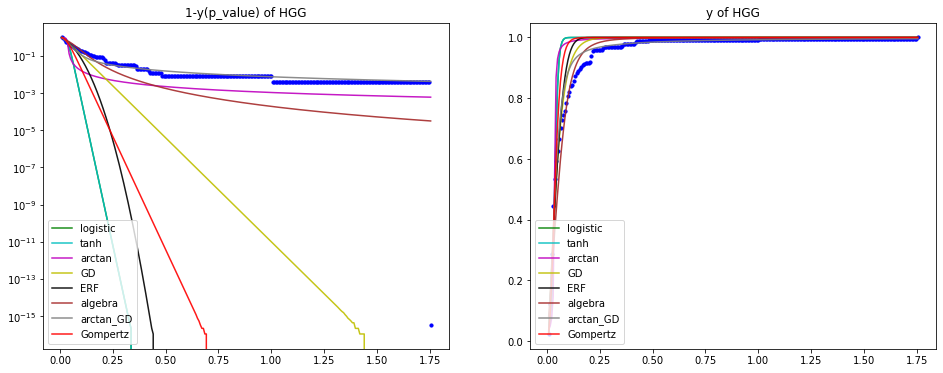

For  SF  :
curve_fit parameter on logistic:  [8.8737892  0.95707635]
curve_fit parameter on tanh:  [8.87380537 0.47853658]
curve_fit parameter on arctan:  [8.84069932 7.99729034]
curve_fit parameter on GD:  [3.26735512 0.02194642]
curve_fit parameter on ERF:  [3.26905175 0.02496129]
curve_fit parameter on algebra:  [9.20819632 0.12761562]
curve_fit parameter on arctan_GD:  [8.8234251  0.92873649 0.05447412]
curve_fit parameter on Gompertz:  [-31.46973762 -12.02908256]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


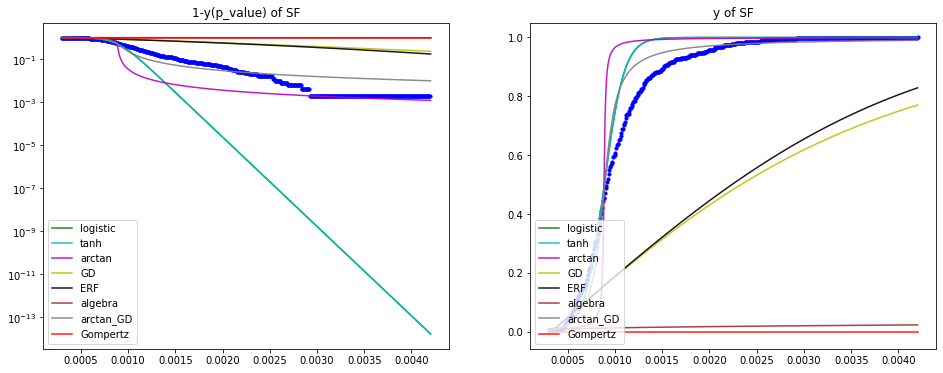

For  SFDD  :
curve_fit parameter on logistic:  [ 0.21360223 16.13795398]
curve_fit parameter on tanh:  [0.213601   8.06906919]
curve_fit parameter on arctan:  [ 0.20392524 20.22757802]
curve_fit parameter on GD:  [0.05985405 2.99757709]
curve_fit parameter on ERF:  [0.05692126 3.07540499]
curve_fit parameter on algebra:  [ 0.21892582 20.90827439]
curve_fit parameter on arctan_GD:  [0.11934433 4.34147595 0.55967988]
curve_fit parameter on Gompertz:  [1.63462842 9.5625006 ]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


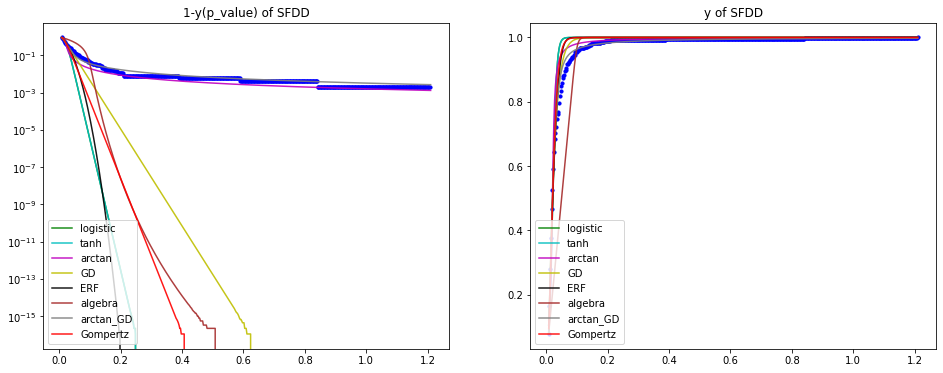

For  Sticky  :
curve_fit parameter on logistic:  [75.12290524  0.14659262]
curve_fit parameter on tanh:  [7.51227377e+01 7.32966597e-02]
curve_fit parameter on arctan:  [76.8186289   1.46047524]
curve_fit parameter on GD:  [3.76293790e+01 2.90459006e-03]
curve_fit parameter on ERF:  [3.76511554e+01 3.33327595e-03]
curve_fit parameter on algebra:  [78.50832208  0.10087706]
curve_fit parameter on arctan_GD:  [7.56015141e+01 1.28781287e-01 5.81757117e-02]
curve_fit parameter on Gompertz:  [1. 1.]



/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


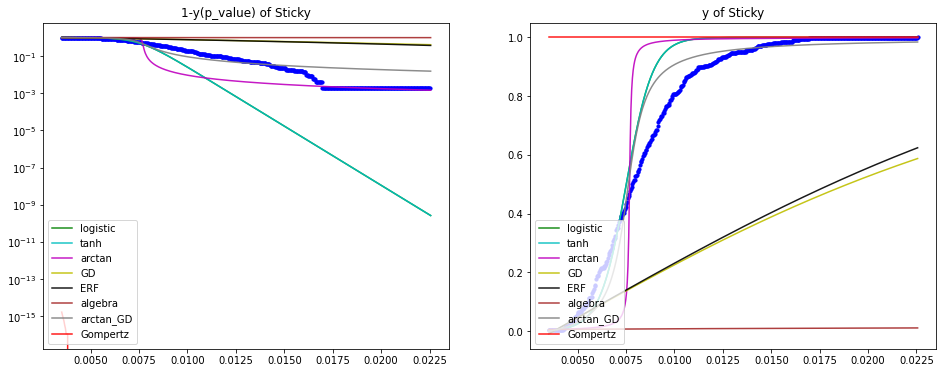

In [20]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_CE,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors_CE[i], functions, colors)